My first model for computer vision _video_✨

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}, {torch.__version__}, {torchvision.__version__}")

cuda, 2.5.1, 0.20.1


### 1. Getting dataset
* FashioMNIST

In [2]:
train_data = datasets.FashionMNIST(
    root='data', # where to download data to
    train=True, # do we want the training dataset
    download=True, # do we ant to download it
    transform= torchvision.transforms.ToTensor(), #transform the data to tensor
    target_transform=None # how to transform the label/targets
)

test_data = datasets.FashionMNIST(
    root= 'data',
    train= False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
# see 1st training example

image, label = train_data[0]
# image, label

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [8]:
image.shape, label
class_names[label]

'Ankle boot'

## 1.2 Visualizing data

Text(0.5, 1.0, '9')

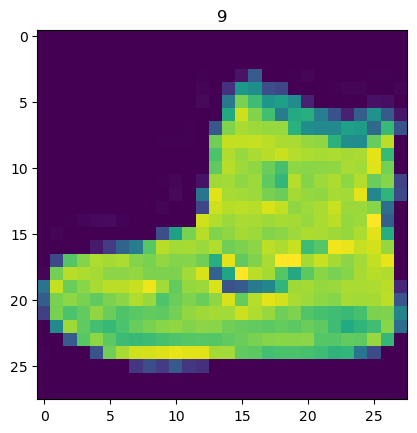

In [9]:
image, label = train_data[0]

plt.imshow(image.squeeze()); plt.title(label)

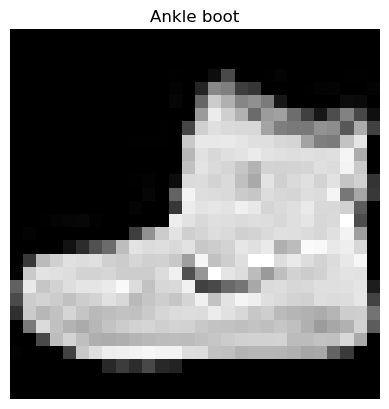

In [10]:
import matplotlib.pyplot as plt

plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])

# Get the current axis and turn it off
ax = plt.gca()
ax.set_axis_off()

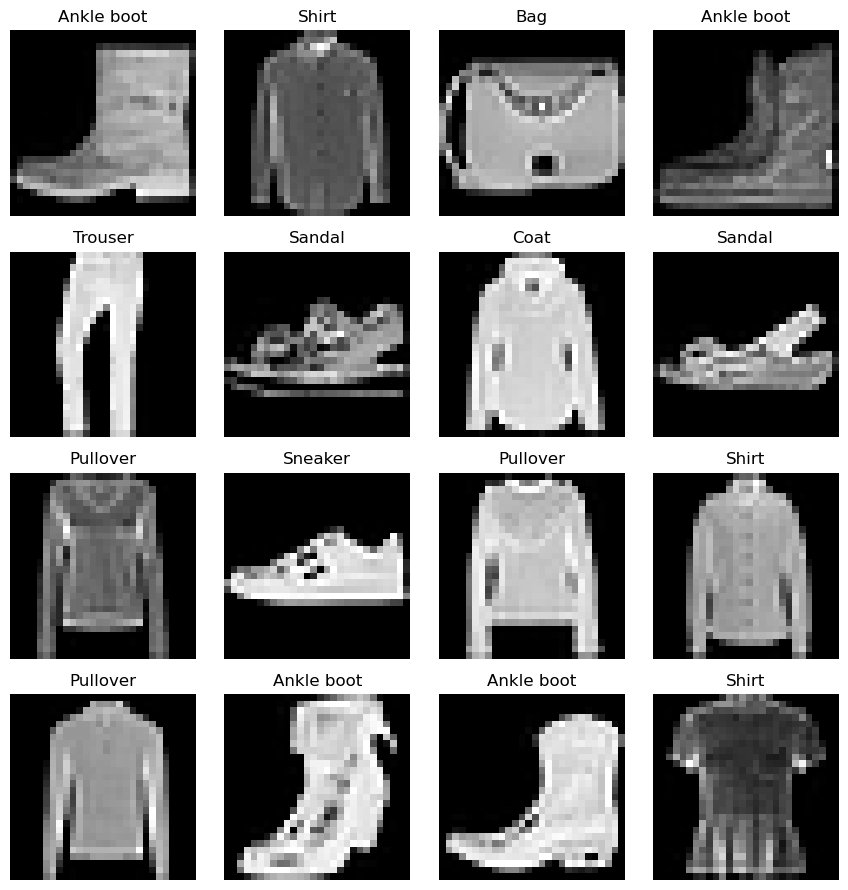

In [11]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), (1,)).item()  # Corrected randint usage
    img, label = train_data[random_idx]
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(class_names[label])
    ax.axis('off')
    plt.tight_layout()

Is this a linear or a non-linear problem?

In [12]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [13]:
## 2. Prepare Dataloader

from torch.utils.data import DataLoader

# HYPERPARAMETERS
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2865c15b190>,
 <torch.utils.data.dataloader.DataLoader at 0x2865c15bbe0>)

In [14]:
print(f'dataloaders: {train_dataloader, test_dataloader}')
print(f'len or train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'len or test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}')

dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000002865C15B190>, <torch.utils.data.dataloader.DataLoader object at 0x000002865C15BBE0>)
len or train dataloader: 1875 batches of 32
len or test dataloader: 313 batches of 32


In [15]:
# check whats inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

image size: torch.Size([1, 28, 28])
label: 8, label size: torch.Size([])


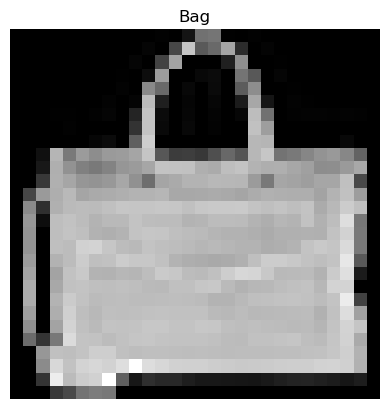

In [16]:
# show sample

# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
print(f"image size: {img.shape}")
print(f"label: {label}, label size: {label.shape}")

## Model 0: Building baseline model
* best practice  to start with a baseline model
* a simple model to try and improve upon with subsequent models or experiments

In [17]:
# create a flatten layer

flatten_model = nn.Flatten()

# get a single sample
x = train_features_batch[0]
x.shape

# flatten the sample 
output = flatten_model(x) # perform forward pass

print(x.shape) # before flattening
print(output.shape) # after flatenning

torch.Size([1, 28, 28])
torch.Size([1, 784])


In [18]:
from torch import nn

class FashioMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [19]:
torch.manual_seed(42)

# setup model with input params
model_0 = FashioMNISTModelV0(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to('cpu')

model_0

FashioMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [20]:
dummy_x = torch.rand([1,1,28,28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [21]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### setup loss fn, optimizer, eval metrics
* loss - nn.CrossEntrophyLoss
* optim - torch.optim.SGD
* eval_met - acc

In [22]:
import requests
from pathlib import Path

HELPER_FUNCTIONS_URL = 'https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py'
HELPER_FUNCTIONS_PATH = Path('helper_functions.py')

def download_helper_functions():
    """
    Downloads the helper_functions.py file if it does not already exist.
    """
    if HELPER_FUNCTIONS_PATH.is_file():
        print(f"'{HELPER_FUNCTIONS_PATH.name}' already exists, skipping download...")
    else:
        print(f"Downloading '{HELPER_FUNCTIONS_PATH.name}'...")
        try:
            response = requests.get(HELPER_FUNCTIONS_URL)
            response.raise_for_status()  # Raise an error for bad responses
            with open(HELPER_FUNCTIONS_PATH, 'wb') as file:
                file.write(response.content)
            print(f"'{HELPER_FUNCTIONS_PATH.name}' downloaded successfully.")
        except requests.exceptions.RequestException as e:
            print(f"An error occurred while downloading '{HELPER_FUNCTIONS_PATH.name}': {e}")

download_helper_functions()

'helper_functions.py' already exists, skipping download...


In [23]:
# import accuracy metric

from helper_functions import accuracy_fn

#setup loss and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

### 3.2 Creating a function to time experiments

* track: models performance(loss and acc values), how fast it runs

In [24]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end-start
    print(f"Train time on {device}: {total_time:.3f} sec")
    return total_time

In [25]:
start_time = timer()
end_time = timer()
print_train_time(start=start_time, end=end_time, device='cpu')

Train time on cpu: 0.000 sec


0.00010890000021390733

### Creating a training loop and training a model on batches of data

1. Loop through epochs
2. Loop through batches, perform training steps, calc train loss __per batch__
3. Loop though testing batches, perform testing steps, calculate the test loss per batch
4. print whats happening
5. time it all

In [26]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train() 
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)
           
            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

c:\ProgramData\miniconda3\envs\ML_3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:17<00:35, 17.69s/it]


Train loss: 0.90961 | Test loss: 0.62902, Test acc: 78.63%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:31<00:15, 15.52s/it]


Train loss: 0.55733 | Test loss: 0.54409, Test acc: 81.13%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:46<00:00, 15.41s/it]


Train loss: 0.50266 | Test loss: 0.51368, Test acc: 82.00%

Train time on cpu: 46.248 sec


In [27]:
str(next(model_0.parameters()).device)

'cpu'

## 4.4 Make Predictions and get model_0's results

In [28]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """
    Returns a dictionary containing the results of model predicting on data_loader.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

100%|██████████| 313/313 [00:02<00:00, 129.93it/s]


{'model_name': 'FashioMNISTModelV0',
 'model_loss': 0.5136752128601074,
 'model_acc': 81.9988019169329}

## 5. Setup device agnostic code (although already done in the imports above)

In [29]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

!nvidia-smi
torch.cuda.is_available()

Sat Jan 18 15:48:39 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti    WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P5                7W /  N/A|     48MiB /  4096MiB |     23%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

## building a better model with a capacity for non-linearity 

In [30]:
class FashioMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flattern inputs into a single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [31]:
# create instance of m1

torch.manual_seed(42)
model_1 = FashioMNISTModelV1(input_shape=784,
                             hidden_units=10,
                             output_shape=len(class_names)).to(device)

next(model_1.parameters()).device

device(type='cuda', index=0)

## 6. setup loss, optimizer and evaluation metrics

In [32]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), # update model's parameters to reduce loss
                            lr=0.1)

### 6.2 FUnctionizing training and evaluation/testing loops

In [33]:
import torch.utils
import torch.utils.data
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """
    Perform a training with model trying to learn on data_loader.
    """

    ### Training
    train_loss, train_acc = 0, 0

    model.train() 

    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(data_loader):
        # device agnostic code
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss, acc by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f}%")

In [34]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.optim.Optimizer,
              accuracy_fn,
              device: torch.device = device):
    """Perform testing and probably saving its parameters"""
     ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model.eval()

    with torch.inference_mode():
        for (X, y) in data_loader:

            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model(X) # output raw logits
           
            # calculate loss
            test_loss = loss_fn(test_pred, y)

            # 3. Calculate accuracy (preds need to be same as y_true), logits -> prediction labels
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1)) 
        
        # adjust metrics
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(data_loader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(data_loader)

    ## Print out what's happening
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [35]:
torch.manual_seed(42)

# Calculate training time      
train_time_start_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"epoch: {epoch}----")

    train_step(model=model_1,
               optimizer=optimizer,
               loss_fn=loss_fn,
               data_loader=train_dataloader,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_step(device=device,
              accuracy_fn=accuracy_fn,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              model=model_1)

# measure train time
train_time_end_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_gpu, 
                                           end=train_time_end_gpu,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 1.09199 | Train acc: 61.34333%


 33%|███▎      | 1/3 [00:31<01:03, 31.58s/it]

Test loss: 0.00219 | Test acc: 65.00%

epoch: 1----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.78101 | Train acc: 71.92833%


 67%|██████▋   | 2/3 [01:03<00:31, 31.85s/it]

Test loss: 0.00127 | Test acc: 73.91%

epoch: 2----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.67027 | Train acc: 75.93667%


100%|██████████| 3/3 [01:24<00:00, 28.25s/it]

Test loss: 0.00127 | Test acc: 75.02%

Train time on cuda: 84.747 sec


In [36]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn,
               device = device):
    """
    Returns a dictionary containing the results of model predicting on data_loader.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [37]:
# Get result dictionary

model_1_results = eval_model(accuracy_fn=accuracy_fn,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             model=model_1,
                             device=device)
model_1_results

100%|██████████| 313/313 [00:03<00:00, 81.19it/s]


{'model_name': 'FashioMNISTModelV1',
 'model_loss': 0.6850008368492126,
 'model_acc': 75.01996805111821}

In [38]:
model_0_results

{'model_name': 'FashioMNISTModelV0',
 'model_loss': 0.5136752128601074,
 'model_acc': 81.9988019169329}

# 7. Building cnn (convolutional neural network)

In [39]:
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(f"Output of conv_block1: {x.shape}")
        x = self.block_2(x)
        # print(f"Output of conv_block2: {x.shape}")
        x = self.classifier(x)
        # print(f"Output of classifier: {x.shape}")
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
# model_2

In [40]:
# model_2(rand_image_ternsor.unsqueeze(0).to(device))

## 7.1 Stepping through nn.conv2d



In [41]:
# model_2.state_dict()

images = torch.rand(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0]

In [42]:
# craet a single conv2d layer

torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=(3,3),
                       stride=1,
                       padding=1)

# pass the data through convolutional layer

conv_output = conv_layer(test_image)
# conv_output
print(f"{test_image.shape} | {conv_output.shape}")

torch.Size([3, 64, 64]) | torch.Size([10, 64, 64])


### 7.2 Stepping through nn.MaxPool2d

In [43]:
# createa sample nn.maxpoool2d layer
maxpool_layer = nn.MaxPool2d(kernel_size=2)

# pass data through the convolutional layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data thgouth the maxpool layer
test_image_through_conv_and_max = maxpool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool layer: {test_image_through_conv_and_max.shape}")

Shape after going through conv_layer(): torch.Size([1, 10, 64, 64])
Shape after going through conv_layer() and max_pool layer: torch.Size([1, 10, 32, 32])


In [44]:
torch.manual_seed(42)

# create random tensor with a similar number of dimensions to the images
random_tensor = torch.randn(size=(1,1,2,2))

# maxpool layer
maxpool_layer = nn.MaxPool2d(kernel_size=2)

# pass random tensor through maxpool_layer

maxpool_tensor = maxpool_layer(random_tensor)

random_tensor, random_tensor.shape, "...", maxpool_tensor, maxpool_tensor.shape

(tensor([[[[0.3367, 0.1288],
           [0.2345, 0.2303]]]]),
 torch.Size([1, 1, 2, 2]),
 '...',
 tensor([[[[0.3367]]]]),
 torch.Size([1, 1, 1, 1]))

## 7.3 Setup loss function, optimizer: model_2

In [45]:
# setup lossf/eval metric, optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [46]:
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## 7.4 Training, testing model_2 using training and test functions

In [48]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# train and test model
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n--------------")

    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_step(model=model_2,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
--------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.30585 | Train acc: 88.92167%


 33%|███▎      | 1/3 [00:33<01:06, 33.36s/it]

Test loss: 0.00058 | Test acc: 88.40%

Epoch 1
--------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.29277 | Train acc: 89.37667%


 67%|██████▋   | 2/3 [00:56<00:27, 27.13s/it]

Test loss: 0.00056 | Test acc: 88.82%

Epoch 2
--------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.28247 | Train acc: 89.58833%


100%|██████████| 3/3 [01:19<00:00, 26.47s/it]

Test loss: 0.00038 | Test acc: 89.26%

Train time on cuda: 79.419 sec


In [49]:
# get model 2 results

model_2_results = eval_model(
    data_loader=test_dataloader,
    model=model_2,
        accuracy_fn=accuracy_fn,
    loss_fn=loss_fn,
    device=device
)

model_2_results

100%|██████████| 313/313 [00:05<00:00, 52.80it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.29716551303863525,
 'model_acc': 89.25718849840256}